In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
import krypy
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [88]:
h = 0.1

r1 = 1
r2 = 1

dist = 0.5
sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

wavenumber = 0.8j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

n = mat.shape[0]
Id = np.eye(n)
inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

combined = inv_mat2.dot(mat)
sign, logdet = slogdet(combined)

print(logdet)

-0.1205179135982149


In [89]:
mat.shape[0]

3192

In [99]:
evals, evects = np.linalg.eig(combined)

In [100]:
mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

combined_inverse_free = inv_free_mat2.dot(mat)

In [135]:
dim = 50

In [136]:
X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = dim,  ortho='dmgs')
evals_H, evect_H = np.linalg.eig(H_combined[0:dim, :])  

In [146]:
x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
rho_ = 1

V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = dim, ortho ='dmgs')
A_m = V_m.T @ (mat - rho_*mat2) @ V_m
B_m = V_m.T @ mat2 @ V_m
evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
evals_kry = evalue + rho_

In [138]:
print(list(np.real(evals_H)))

[1.3011497738607751, 0.698850226139227, 1.0591002822253113, 1.0975777184176805, 1.0975821496288818, 0.9024222815823194, 0.9024178503711164, 0.9408997177746893, 1.027033829906865, 1.0270412277029912, 0.9729661700931386, 0.9729587722970101, 1.0215302579258665, 1.0215294954124277, 1.0128877115356563, 0.978470504587574, 0.978469742074131, 0.9871122884643431, 1.0070572686148653, 1.0070563468858051, 1.0063210590617895, 1.0063250290253096, 0.9929436531141955, 0.9929427313851342, 0.9936789409382114, 0.9936749709746894, 1.0048951509038293, 1.0048954101509557, 1.0029373157508248, 0.995104589849068, 0.9951048490995037, 0.9970626842491497, 1.0018006052009456, 1.0016969665068178, 1.0017653887750042, 1.001489251852473, 1.0011362688507301, 1.0006870203577953, 0.9981993786695206, 0.9983034269545646, 0.9985101017774366, 0.998863860733293, 1.000439999845562, 1.0001635764985342, 1.0000393733987427, 1.0000109364623322, 1.000002237299771, 0.9993127063557588, 0.9995575376371632, 0.9996429915516795]


In [140]:
print(list(sorted(np.real(evals_H)))[0:25])

[0.698850226139227, 0.9024178503711164, 0.9024222815823194, 0.9408997177746893, 0.9729587722970101, 0.9729661700931386, 0.978469742074131, 0.978470504587574, 0.9871122884643431, 0.9929427313851342, 0.9929436531141955, 0.9936749709746894, 0.9936789409382114, 0.995104589849068, 0.9951048490995037, 0.9970626842491497, 0.9981993786695206, 0.9983034269545646, 0.9985101017774366, 0.998863860733293, 0.9993127063557588, 0.9995575376371632, 0.9996429915516795, 1.000002237299771, 1.0000109364623322]


In [113]:
print(evals)

[1.30114977+0.j 0.69885023+0.j 1.09758215+0.j ... 1.        +0.j
 1.        +0.j 1.        +0.j]


In [129]:
evals_H_100 = [1.301149773860772, 0.6988502261392278, 0.9024222815823186, 0.9024178503711168, 1.0975777184176814, 1.0975821496288836, 1.0591002822253095, 0.9408997177746882, 1.0270338299068658, 1.0270412277029846, 0.9729661700931395, 0.9729587722970076, 1.0215302579258694, 1.0215294954124285, 0.978469742074134, 0.978470504587574, 1.0128877115356603, 0.9871122884643421, 0.9929436531141932, 0.992942731385133, 0.9936789409382083, 0.9936749709746912, 1.0070572686148653, 1.0070563468858045, 1.0063210590617884, 1.0063250290253067, 0.9951045898490847, 1.0048951509037414, 1.0048954101509169, 0.9951048490962605, 1.0029373157508237, 0.9970626842491789, 1.0018006216847355, 1.0017995535309874, 1.001696484778422, 1.0016971580891183, 0.9981993783152631, 0.9982004464690151, 0.9983035152215767, 0.9983028419108801, 1.001489042276993, 1.0014899458288626, 0.998510054171134, 0.9985109577230117, 1.001136087262774, 1.001136196910816, 0.9988638030891788, 0.998863912737227, 1.0006870203524838, 0.999312979647521, 1.0004546408316939, 1.0004545830685305, 1.0004389136965348, 1.000438515618003, 1.0004086790808604, 1.0004084055180877, 0.9995610863034606, 0.9995614843820011, 0.9995454169314721, 0.9995453591683097, 1.0003535175041065, 1.0003531089150262, 0.9995913209191472, 0.9995915944819057, 0.999646891084971, 0.9996464824958949, 1.000267414158628, 1.000267462941618, 1.000163574007856, 0.9997325370583788, 0.9997325858413721, 0.9998364259921444, 1.0000635452514848, 1.0001142580364293, 1.000111551984199, 1.0000843143447902, 1.0001069733618453, 1.0001029249183286, 1.000098528482423, 1.0000394228303202, 0.9999364547081113, 0.999901517279739, 0.9998857850053959, 0.9998930433238712, 0.9999156387882433, 0.9999605791803017, 1.0000095718759208, 1.0000023284843798, 1.00009769636671, 1.0000006355938877, 1.00000015631274, 1.000027887213357, 0.9999741745884145, 0.9998884528068188, 0.9998884528068188, 0.9999116927722409, 1.0000319686174337, 1.0000208052924695, 0.9999792793487163, 0.9999916380213553]
evals_H_100_s = [0.6988502261392278, 0.9024178503711168, 0.9024222815823186, 0.9408997177746882, 0.9729587722970076, 0.9729661700931395, 0.978469742074134, 0.978470504587574, 0.9871122884643421, 0.992942731385133, 0.9929436531141932, 0.9936749709746912, 0.9936789409382083, 0.9951045898490847, 0.9951048490962605, 0.9970626842491789, 0.9981993783152631, 0.9982004464690151, 0.9983028419108801, 0.9983035152215767, 0.998510054171134, 0.9985109577230117, 0.9988638030891788, 0.998863912737227, 0.999312979647521, 0.9995453591683097, 0.9995454169314721, 0.9995610863034606, 0.9995614843820011, 0.9995913209191472, 0.9995915944819057, 0.9996464824958949, 0.999646891084971, 0.9997325370583788, 0.9997325858413721, 0.9998364259921444, 0.9998857850053959, 0.9998884528068188, 0.9998884528068188, 0.9998930433238712, 0.999901517279739, 0.9999116927722409, 0.9999156387882433, 0.9999364547081113, 0.9999605791803017, 0.9999741745884145, 0.9999792793487163, 0.9999916380213553, 1.00000015631274, 1.0000006355938877]
evals_H_100_l = [1.0000023284843798, 1.0000095718759208, 1.0000208052924695, 1.000027887213357, 1.0000319686174337, 1.0000394228303202, 1.0000635452514848, 1.0000843143447902, 1.00009769636671, 1.000098528482423, 1.0001029249183286, 1.0001069733618453, 1.000111551984199, 1.0001142580364293, 1.000163574007856, 1.000267414158628, 1.000267462941618, 1.0003531089150262, 1.0003535175041065, 1.0004084055180877, 1.0004086790808604, 1.000438515618003, 1.0004389136965348, 1.0004545830685305, 1.0004546408316939, 1.0006870203524838, 1.001136087262774, 1.001136196910816, 1.001489042276993, 1.0014899458288626, 1.001696484778422, 1.0016971580891183, 1.0017995535309874, 1.0018006216847355, 1.0029373157508237, 1.0048951509037414, 1.0048954101509169, 1.0063210590617884, 1.0063250290253067, 1.0070563468858045, 1.0070572686148653, 1.0128877115356603, 1.0215294954124285, 1.0215302579258694, 1.0270338299068658, 1.0270412277029846, 1.0591002822253095, 1.0975777184176814, 1.0975821496288836, 1.301149773860772]

err_H_100_s = [(1.5886422914370948e-15+0j), (4.305966005204811e-15+0j), (2.3375129247574673e-15+0j), (1.1799589304277116e-16+0j), (2.8526980182420416e-15+0j), (5.705352656397484e-16+0j), (1.5885133363249763e-15+0j), (4.538605995458664e-16+0j), (1.012246259964108e-15+0j), (1.5653593962130988e-15+0j), (1.5653579431223409e-15+0j), (1.1172899157721e-16+0j), (3.5753134462587075e-15+0j), (2.9007803737124635e-15+0j), (5.801559235987926e-15+0j), (4.4539748289193915e-15+0j), (2.2244514447583942e-15+0j), (6.673347193256056e-16+0j), (3.89238658156091e-15+0j), (1.6681645527093087e-15+0j), (5.448210358962358e-15+0j), (5.559393294776106e-16+0j), (7.780401240230189e-16+0j), (1.8895258080659873e-15+0j), (2.11087396015995e-15+0j), (5.8868584367290126e-15+0j), (1.6660919141124986e-15+0j), (2.9989184328629014e-15+0j), (2.887846229699518e-15+0j), (2.1102861766027923e-15+0j), (3.7763005457063675e-15+0j), (1.7769850347145517e-15+0j), (9.995536734757943e-16+0j), (9.994680428254323e-16+0j), (1.221571992734314e-15+0j), (1.887687918541179e-15+0j), (4.312791778240261e-08+0j), (2.661277388087542e-06+0j), (3.530655731178561e-08+0j), (4.59534278686744e-06+0j), (8.48971684985622e-06+0j), (1.853309583301616e-05+0j), (1.4173022781420857e-05+0j), (3.4940437797644993e-05+0j), (4.49596546733931e-05+0j), (5.843402842850239e-05+0j), (4.284259765314687e-05+0j), (5.5186582877113285e-05+0j), (3.958070291192564e-05+0j), (2.9257329490317156e-05+0j)]
err_H_100_l = [(2.6291661358029952e-05+0j), (2.9849777105189465e-05+0j), (4.2737046487626155e-05+0j), (3.5671045208721394e-05+0j), (5.228149429862552e-05+0j), (4.4950057762952714e-05+0j), (3.4933596851359235e-05+0j), (1.4217092394992473e-05+0j), (9.141000226668701e-06+0j), (8.442143456925678e-06+0j), (8.625625769302912e-06+0j), (4.608619706774571e-06+0j), (2.655879109807969e-06+0j), (8.11551358943962e-11+0j), (1.5540580309746493e-15+0j), (1.5538967004964586e-15+0j), (1.9978670889167145e-15+0j), (6.658986800146761e-16+0j), (2.663593632127585e-15+0j), (7.990342477341906e-15+0j), (2.2195389701040775e-16+0j), (4.4389455515488053e-16+0j), (2.4414190819013105e-15+0j), (3.99498683527626e-15+0j), 0j, (4.4378432098942987e-16+0j), (2.883304178873078e-15+0j), (6.21019293587153e-15+0j), (4.4342892543325107e-16+0j), (7.316570668576754e-15+0j), (4.4333709521631814e-16+0j), (1.1083419930461476e-15+0j), (8.865829661928005e-16+0j), (1.994809546998036e-15+0j), (8.855771998424585e-16+0j), (3.977333242235339e-15+0j), (1.1048145044850216e-15+0j), (1.5445490487144636e-15+0j), (1.985840942722913e-15+0j), (3.3073313962770157e-15+0j), (3.0868398112315076e-15+0j), (3.0690711650923253e-15+0j), 0j, (4.347293742935704e-16+0j), (1.9457990439385024e-15+0j), (3.891570056627176e-15+0j), (1.4675779626924527e-15+0j), (1.8207379858314413e-15+0j), (4.855281693495653e-15+0j), (3.071746980204467e-15+0j)]

evals_kry_100 = [0.6990079008057447, 0.9025043584331328, 0.9025094566331568, 0.940961958852211, 0.9729877086100008, 0.9730009556994748, 0.9785039552823984, 0.9785065562844443, 0.9871338463283298, 0.9929528024436651, 0.9929530246447991, 0.993688292933497, 0.9936889001165182, 0.9951159205505223, 0.9951222863657728, 0.9970694640814092, 0.9982025343094175, 0.9982030796165547, 0.9983069277531932, 0.9983072386319717, 0.9985140458851315, 0.9985148099344352, 0.9988695808906239, 0.9988792301834301, 0.9993154269738042, 0.9995485903149443, 0.9995645377743517, 0.9995654828281576, 0.9995732280552276, 0.9995947791769609, 0.9995965850913497, 0.9996508775750801, 0.9996523955624209, 0.9997379929444221, 0.9998103832647615, 0.9998388465716685, 0.999892876362753, 0.9999033158338543, 0.9999054286807312, 0.9999115045644985, 0.9999158957858043, 0.999927576807508, 0.999941052856855, 0.999942974623358, 0.99995626975889, 0.999971967305853, 0.9999775501235972, 0.9999834519883184, 0.999993202722962, 0.99999857485611, 1.0000003726138238, 1.0000067529242451, 1.0000138167899741, 1.0000209985126964, 1.0000373111239194, 1.0000390740991814, 1.000040277974358, 1.000057540235799, 1.0000609116113888, 1.0000726071529247, 1.0000804237313714, 1.0000898685084358, 1.0000956084485666, 1.0001019735692562, 1.0001028636741336, 1.0001630390267895, 1.0002581977449287, 1.000261194631266, 1.000348648207507, 1.0003490846719356, 1.0003843848439546, 1.0004041924654252, 1.0004050923906913, 1.0004351697939016, 1.000441630331333, 1.0004530812032693, 1.0006853678394754, 1.00112967850199, 1.0011304176237454, 1.0014852653155935, 1.0014861044793204, 1.0016927480674382, 1.0016932277912538, 1.0017956313813674, 1.0017970279506214, 1.002931119107496, 1.0048836236785657, 1.004884446895275, 1.006311295969476, 1.0063117469354184, 1.007046875087562, 1.0070474196102566, 1.0128677532216437, 1.0214938193476157, 1.021495865870226, 1.0270000224946556, 1.0270148607107965, 1.0590386022130054, 1.0974885918173718, 1.0974946114390227, 1.3010144869655342]
evals_kry_100_s = [0.6990079008057447, 0.9025043584331328, 0.9025094566331568, 0.940961958852211, 0.9729877086100008, 0.9730009556994748, 0.9785039552823984, 0.9785065562844443, 0.9871338463283298, 0.9929528024436651, 0.9929530246447991, 0.993688292933497, 0.9936889001165182, 0.9951159205505223, 0.9951222863657728, 0.9970694640814092, 0.9982025343094175, 0.9982030796165547, 0.9983069277531932, 0.9983072386319717, 0.9985140458851315, 0.9985148099344352, 0.9988695808906239, 0.9988792301834301, 0.9993154269738042, 0.9995485903149443, 0.9995645377743517, 0.9995654828281576, 0.9995732280552276, 0.9995947791769609, 0.9995965850913497, 0.9996508775750801, 0.9996523955624209, 0.9997379929444221, 0.9998103832647615, 0.9998388465716685, 0.999892876362753, 0.9999033158338543, 0.9999054286807312, 0.9999115045644985, 0.9999158957858043, 0.999927576807508, 0.999941052856855, 0.999942974623358, 0.99995626975889, 0.999971967305853, 0.9999775501235972, 0.9999834519883184, 0.999993202722962, 0.99999857485611]
evals_kry_100_l = [1.0000067529242451, 1.0000138167899741, 1.0000209985126964, 1.0000373111239194, 1.0000390740991814, 1.000040277974358, 1.000057540235799, 1.0000609116113888, 1.0000726071529247, 1.0000804237313714, 1.0000898685084358, 1.0000956084485666, 1.0001019735692562, 1.0001028636741336, 1.0001630390267895, 1.0002581977449287, 1.000261194631266, 1.000348648207507, 1.0003490846719356, 1.0003843848439546, 1.0004041924654252, 1.0004050923906913, 1.0004351697939016, 1.000441630331333, 1.0004530812032693, 1.0006853678394754, 1.00112967850199, 1.0011304176237454, 1.0014852653155935, 1.0014861044793204, 1.0016927480674382, 1.0016932277912538, 1.0017956313813674, 1.0017970279506214, 1.002931119107496, 1.0048836236785657, 1.004884446895275, 1.006311295969476, 1.0063117469354184, 1.007046875087562, 1.0070474196102566, 1.0128677532216437, 1.0214938193476157, 1.021495865870226, 1.0270000224946556, 1.0270148607107965, 1.0590386022130054, 1.0974885918173718, 1.0974946114390227, 1.3010144869655342]

err_kry_100_s = [(0.00022562011231921133+0j), (9.586253416483479e-05+0j), (9.660117288244917e-05+0j), (6.615059644204874e-05+0j), (2.974053352968646e-05+0j), (3.575212315080992e-05+0j), (3.496603604062044e-05+0j), (3.684495005386496e-05+0j), (2.1839322882158658e-05+0j), (1.0142637850342837e-05+0j), (9.43812931874465e-06+0j), (1.3406756932500914e-05+0j), (1.0022531318788177e-05+0j), (1.1386442747959586e-05+0j), (1.75230474681873e-05+0j), (6.7998054102720225e-06+0j), (3.1616871591374364e-06+0j), (2.637894572835854e-06+0j), (4.092788418124735e-06+0j), (3.7297378368091033e-06+0j), (3.997670304208061e-06+0j), (3.8579560826709635e-06+0j), (5.784373631846972e-06+0j), (1.533486794935533e-05+0j), (2.449008804184975e-06+0j), (3.232616308068426e-06+0j), (1.912953884238417e-05+0j), (4.398455236219338e-06+0j), (1.1748825272800452e-05+0j), (3.4596717113465386e-06+0j), (4.992648465441704e-06+0j), (4.396633470263317e-06+0j), (5.506421815591757e-06+0j), (5.457345682010605e-06+0j), (7.78182330878626e-05+0j), (2.4209755309369973e-06+0j), (7.1352956126158555e-06+0j), (1.7526002096504995e-05+0j), (1.7013074891437152e-05+0j), (2.3058643023141053e-05+0j), (2.286976117052147e-05+0j), (3.441882830544814e-05+0j), (3.958959576016273e-05+0j), (4.146099520375614e-05+0j), (4.0649869616315945e-05+0j), (5.6226559877800514e-05+0j), (4.1113262616606695e-05+0j), (4.7000029625267047e-05+0j), (3.262683899284052e-05+0j), (2.7196532730709093e-05+0j)]
err_kry_100_l = [(2.1867348120479633e-05+0j), (2.560503039174152e-05+0j), (4.25438385381064e-05+0j), (2.6247733597006412e-05+0j), (4.517661116947064e-05+0j), (4.4094985873277114e-05+0j), (4.093802120772356e-05+0j), (3.761752008584171e-05+0j), (3.422753380838747e-05+0j), (2.6544958022857356e-05+0j), (2.1680579362362595e-05+0j), (1.5972265001559873e-05+0j), (1.2233200244276863e-05+0j), (1.1393141701175625e-05+0j), (5.348935734265344e-07+0j), (9.213949760262644e-06+0j), (6.2666342614515735e-06+0j), (4.459132960202893e-06+0j), (4.431265643580586e-06+0j), (2.4010867970116508e-05+0j), (4.484782598120933e-06+0j), (3.340857712918853e-05+0j), (3.742260106472176e-06+0j), (1.2946851773876317e-05+0j), (1.558919676091895e-06+0j), (1.6513784773644744e-06+0j), (6.401488137588767e-06+0j), (5.772728120821403e-06+0j), (3.7713457059959853e-06+0j), (3.835634661695129e-06+0j), (3.7303824471530816e-06+0j), (3.923638830226888e-06+0j), (3.915104179533976e-06+0j), (3.587274791291358e-06+0j), (6.178495135605375e-06+0j), (1.1471072548566337e-05+0j), (1.0909847462857688e-05+0j), (9.701766872525294e-06+0j), (1.3198608309723587e-05+0j), (9.40543026715509e-06+0j), (9.779984633266411e-06+0j), (1.9704369779755078e-05+0j), (3.4924165159227785e-05+0j), (3.366719230887891e-05+0j), (3.291752542875418e-05+0j), (2.5672768999761843e-05+0j), (5.8238122808312836e-05+0j), (8.120299712357682e-05+0j), (7.975547880017418e-05+0j), (0.00010397488279950901+0j)]

In [157]:
evals_H_50 = [1.3011497738607751, 0.698850226139227, 1.0591002822253113, 1.0975777184176805, 1.0975821496288818, 0.9024222815823194, 0.9024178503711164, 0.9408997177746893, 1.027033829906865, 1.0270412277029912, 0.9729661700931386, 0.9729587722970101, 1.0215302579258665, 1.0215294954124277, 1.0128877115356563, 0.978470504587574, 0.978469742074131, 0.9871122884643431, 1.0070572686148653, 1.0070563468858051, 1.0063210590617895, 1.0063250290253096, 0.9929436531141955, 0.9929427313851342, 0.9936789409382114, 0.9936749709746894, 1.0048951509038293, 1.0048954101509557, 1.0029373157508248, 0.995104589849068, 0.9951048490995037, 0.9970626842491497, 1.0018006052009456, 1.0016969665068178, 1.0017653887750042, 1.001489251852473, 1.0011362688507301, 1.0006870203577953, 0.9981993786695206, 0.9983034269545646, 0.9985101017774366, 0.998863860733293, 1.000439999845562, 1.0001635764985342, 1.0000393733987427, 1.0000109364623322, 1.000002237299771, 0.9993127063557588, 0.9995575376371632, 0.9996429915516795]
evals_H_50_s = [0.698850226139227, 0.9024178503711164, 0.9024222815823194, 0.9408997177746893, 0.9729587722970101, 0.9729661700931386, 0.978469742074131, 0.978470504587574, 0.9871122884643431, 0.9929427313851342, 0.9929436531141955, 0.9936749709746894, 0.9936789409382114, 0.995104589849068, 0.9951048490995037, 0.9970626842491497, 0.9981993786695206, 0.9983034269545646, 0.9985101017774366, 0.998863860733293, 0.9993127063557588, 0.9995575376371632, 0.9996429915516795, 1.000002237299771, 1.0000109364623322]
evals_H_50_l = [1.0000393733987427, 1.0001635764985342, 1.000439999845562, 1.0006870203577953, 1.0011362688507301, 1.001489251852473, 1.0016969665068178, 1.0017653887750042, 1.0018006052009456, 1.0029373157508248, 1.0048951509038293, 1.0048954101509557, 1.0063210590617895, 1.0063250290253096, 1.0070563468858051, 1.0070572686148653, 1.0128877115356563, 1.0215294954124277, 1.0215302579258665, 1.027033829906865, 1.0270412277029912, 1.0591002822253113, 1.0975777184176805, 1.0975821496288818, 1.3011497738607751]

err_H_50_s = [(2.7006918954430615e-15+0j), (4.675048805650938e-15+0j), (1.4763239524784006e-15+0j), (1.2979548234704828e-15+0j), (2.2821584145936334e-16+0j), (1.483391690663346e-15+0j), (1.4750480980160495e-15+0j), (4.538605995458664e-16+0j), (2.024492519928216e-15+0j), (3.354341563313783e-16+0j), (7.826789715611704e-16+0j), (1.89939285681257e-15+0j), (4.469141807823384e-16+0j), (1.3834491013090211e-14+0j), (3.253335910027075e-12+0j), (2.483090967122561e-14+0j), (3.5489877108311116e-10+0j), (0.00010316613853912766+0j), (0.00020761221730656825+0j), (0.0005612977447948952+0j), (0.0008038498773911281+0j), (0.0010481406398759178+0j), (0.0007800747810563587+0j), (0.001139619269478611+0j), (0.0006984366550102384+0j)]
err_H_50_l = [(0.0006472023125797271+0j), (0.0009714071609401368+0j), (0.0006954069460362894+0j), (0.0008008294502891741+0j), (0.0003531508025745583+0j), (0.00020688195386382513+0j), (1.9125770701399812e-07+0j), (3.410338511517736e-05+0j), (1.645416416221727e-08+0j), (1.9925486996455315e-15+0j), (8.352399808694211e-14+0j), (3.9773322161460774e-14+0j), (4.4129972820413245e-16+0j), (8.825959745435169e-16+0j), (2.6458651170216125e-15+0j), (3.0868398112315076e-15+0j), (8.768774757406644e-16+0j), (8.694593975884518e-16+0j), (2.391011558614637e-15+0j), (2.5943987252513366e-15+0j), (2.5943800377514508e-15+0j), (3.144809920055256e-15+0j), (2.6299548684231932e-15+0j), (6.473708924660871e-15+0j), (6.826104400454371e-16+0j)]

evals_kry_50 = [0.6991068231770755, 0.9025500180096733, 0.9025679492666142, 0.9409815877532914, 0.9730000009423698, 0.9730182335270332, 0.9785233183565545, 0.9785547498609585, 0.9871668905877745, 0.9929653121263623, 0.9934958893513296, 0.9937098929053058, 0.9938454296890289, 0.9951407861574376, 0.9963449622638988, 0.9970912431922957, 0.9982819688025732, 0.998359418653422, 0.9985669209949646, 0.9988473377118626, 0.9989793963721739, 0.9991855060571635, 0.9995308877286262, 0.9996473738320958, 0.9999297223914109, 1.0000056597493963, 1.0001189776923323, 1.0003638096120437, 1.000673989857116, 1.0007852137999433, 1.0011343634905228, 1.001185016795233, 1.0014366105461556, 1.0016354001813514, 1.001767237212555, 1.002927211370772, 1.0036420246740907, 1.0048577908799878, 1.006238584490098, 1.0062883540201535, 1.006386437936885, 1.0070361180126361, 1.012859756371308, 1.0214445010750275, 1.0214758023600972, 1.0269838668761537, 1.0270007223530182, 1.0590256712150974, 1.097425873158088, 1.097456236585668, 1.3009506647903364]
evals_kry_50_s = [0.6991068231770755, 0.9025500180096733, 0.9025679492666142, 0.9409815877532914, 0.9730000009423698, 0.9730182335270332, 0.9785233183565545, 0.9785547498609585, 0.9871668905877745, 0.9929653121263623, 0.9934958893513296, 0.9937098929053058, 0.9938454296890289, 0.9951407861574376, 0.9963449622638988, 0.9970912431922957, 0.9982819688025732, 0.998359418653422, 0.9985669209949646, 0.9988473377118626, 0.9989793963721739, 0.9991855060571635, 0.9995308877286262, 0.9996473738320958, 0.9999297223914109]
evals_kry_50_l = [1.0001189776923323, 1.0003638096120437, 1.000673989857116, 1.0007852137999433, 1.0011343634905228, 1.001185016795233, 1.0014366105461556, 1.0016354001813514, 1.001767237212555, 1.002927211370772, 1.0036420246740907, 1.0048577908799878, 1.006238584490098, 1.0062883540201535, 1.006386437936885, 1.0070361180126361, 1.012859756371308, 1.0214445010750275, 1.0214758023600972, 1.0269838668761537, 1.0270007223530182, 1.0590256712150974, 1.097425873158088, 1.097456236585668, 1.3009506647903364]

err_kry_50_l = [(0.0005676526712128265+0j), (0.0007714012715739414+0j), (0.0004616824914855364+0j), (0.0007027820049324523+0j), (0.00035505332812194284+0j), (0.0005106017550841259+0j), (0.0002601061017891042+0j), (0.00016385847753321638+0j), (3.332446742380933e-05+0j), (1.0074787219703802e-05+0j), (0.0012470218694235783+0j), (3.743600632257421e-05+0j), (8.195651969039781e-05+0j), (3.64444926812297e-05+0j), (0.0006652149614015475+0j), (2.100238277549045e-05+0j), (2.759947033693006e-05+0j), (8.32030183981532e-05+0j), (5.3307834348772997e-05+0j), (4.86478918796271e-05+0j), (3.943887438768746e-05+0j), (7.04475406746086e-05+0j), (0.00013834579278299025+0j), (0.0001147185595752748+0j), (0.00015302548133934815+0j)]
err_kry_50_s = [(0.00036717028663523545+0j), (0.00014645946830313907+0j), (0.00016141853682741+0j), (8.701243826175973e-05+0j), (4.2374503970150406e-05+0j), (5.3510014524149706e-05+0j), (5.475517547279066e-05+0j), (8.609894012126414e-05+0j), (5.531500729100417e-05+0j), (2.2741232212093898e-05+0j), (0.0005561606999580069+0j), (3.5144218818594864e-05+0j), (0.00016754783054961846+0j), (3.6374375844572046e-05+0j), (0.0012462135711214265+0j), (2.864307688213763e-05+0j), (8.273946979590447e-05+0j), (0.00015925877910591578+0j), (0.00026452802996640386+0j), (0.0005447466446750723+0j), (0.0004700425389547532+0j), (0.0006755542630092794+0j), (0.0006678434411013379+0j), (0.0007843521873965608+0j), (0.0006171667500101387+0j)]

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


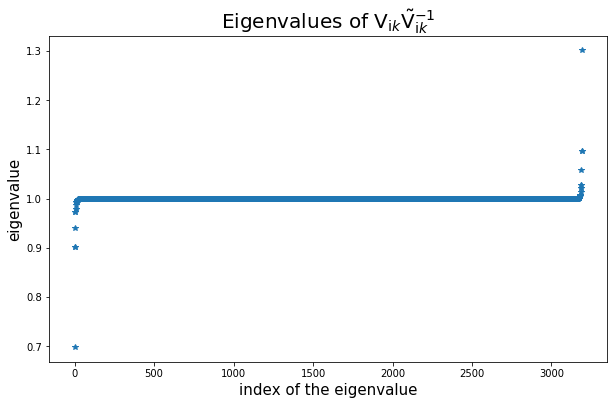

In [198]:
plt.figure(figsize = [10, 6])
plt.plot(range(len(evals)), sorted(evals), '*')
plt.xlabel('index of the eigenvalue', fontsize = 15)
plt.ylabel('eigenvalue', fontsize = 15)
plt.title('Eigenvalues of $\mathsf{V}_{\mathrm{i}k} \~\mathsf{V}_{\mathrm{i}k}^{-1}$', fontsize = 20)
plt.savefig('eigenvalue_of_VVtilde.pdf')

# Standard Arnoldi method

In [134]:
mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

combined_inverse_free = inv_free_mat2.dot(mat)

In [167]:
err_arno = []
for dim in np.arange(5, 500 + 5, 5):
    X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = dim,  ortho='dmgs')
    evals_H, evect_H = np.linalg.eig(H_combined[0:dim, :])  
    
    logdet_ = 0 
    for i in range(len(evals_H)):
        logdet_ += np.log(evals_H[i])
    err_arno.append(abs(logdet - logdet_)/abs(logdet))

In [168]:
print(err_arno)

[3.6484013998624194, 0.24278760828750473, 0.14206684281256113, 0.05209374162015287, 0.09523965213139533, 0.015303313759707286, 0.024974155207839004, 0.02606794292088858, 0.008269273568967147, 0.01353412229346072, 0.009801667314238035, 0.0037299214642288183, 0.003523946445228113, 0.0009895729984765922, 0.0018991131651378086, 0.0028251168757769734, 0.00046111885989221657, 0.0005034972115091508, 0.0009128433968730295, 0.00032628061062406306, 0.0002686462734264619, 0.0001935046201612068, 0.00023265924785313173, 0.00021345767482946492, 5.8281546064761286e-05, 0.0001505262018846464, 0.00013915124275154406, 0.0001371400843070618, 5.658405735473956e-05, 1.8846578276842104e-05, 3.144306753155081e-05, 3.339986439964806e-05, 2.9817157406288615e-05, 7.5199060309952475e-06, 1.4502257164168989e-05, 1.012030835503659e-05, 1.6389214928663675e-05, 1.4355738654496515e-05, 8.995442954970368e-06, 1.126365203602245e-05, 1.3355123385774622e-05, 7.791624998771243e-06, 8.402351646155415e-06, 3.113326465420361

In [172]:
err_arno = [3.6484013998624194, 0.24278760828750473, 0.14206684281256113, 0.05209374162015287, 0.09523965213139533, 0.015303313759707286, 0.024974155207839004, 0.02606794292088858, 0.008269273568967147, 0.01353412229346072, 0.009801667314238035, 0.0037299214642288183, 0.003523946445228113, 0.0009895729984765922, 0.0018991131651378086, 0.0028251168757769734, 0.00046111885989221657, 0.0005034972115091508, 0.0009128433968730295, 0.00032628061062406306, 0.0002686462734264619, 0.0001935046201612068, 0.00023265924785313173, 0.00021345767482946492, 5.8281546064761286e-05, 0.0001505262018846464, 0.00013915124275154406, 0.0001371400843070618, 5.658405735473956e-05, 1.8846578276842104e-05, 3.144306753155081e-05, 3.339986439964806e-05, 2.9817157406288615e-05, 7.5199060309952475e-06, 1.4502257164168989e-05, 1.012030835503659e-05, 1.6389214928663675e-05, 1.4355738654496515e-05, 8.995442954970368e-06, 1.126365203602245e-05, 1.3355123385774622e-05, 7.791624998771243e-06, 8.402351646155415e-06, 3.113326465420361e-06, 2.907194453940195e-06, 3.390772658740736e-06, 4.647510474590806e-06, 3.7489985290060555e-06, 3.3059354807416683e-06, 1.7460977944913064e-06, 3.853525073296669e-06, 3.302602106680245e-06, 7.414954410834847e-07, 7.10523468627446e-07, 7.335529865523996e-07, 6.931097888353677e-07, 7.762344669960116e-07, 3.4330430327727094e-07, 9.46644580723208e-07, 3.464310377384532e-07, 5.493899523328317e-07, 2.158970663308633e-07, 1.4838963138738716e-07, 2.131790450929929e-07, 1.7249036530317605e-07, 1.5172332994501938e-07, 9.199498918240455e-08, 1.9352934472054445e-07, 1.5719032519059462e-07, 1.4000467411223274e-07, 8.321252094251545e-08, 5.866177826389658e-08, 5.8307615755077695e-08, 6.078887785728196e-08, 5.897139416809438e-08, 3.92038463992921e-08, 5.8255490356109054e-08, 5.478556810582477e-08, 5.4758326315166234e-08, 6.281715741575151e-08, 5.438587940074274e-08, 6.632148259747591e-08, 1.7888402775736745e-08, 1.7404774570538312e-08, 1.8087017946311926e-08, 1.5557729253708393e-08, 1.7438195146706477e-08, 1.6561772917226445e-08, 1.5723959633565093e-08, 1.3090866123796548e-08, 1.238494431264405e-08, 6.908841064186314e-09, 1.6354997668818422e-08, 5.634993081892979e-09, 5.601847947503095e-09, 4.891084256796589e-09, 4.632959728811903e-09, 4.475122377756883e-09, 4.108276189592615e-09, 4.899083238037533e-09]
err_kry = [0.6144766423887684, 0.08228721085074128, 0.0942035458970692, 0.03252681153141955, 0.02412157252140442, 0.029608803326728595, 0.003160761264560776, 0.0038448624731575827, 0.005110003863952236, 0.006320687564412544, 0.009077241158411168, 0.0017458202802637518, 0.0019052874294366979, 0.0019157792854761517, 0.0001939583961276505, 0.0036793844725981385, 0.0024649980088236613, 0.0016151268324192537, 0.0018283409028057667, 0.0022353677275055105, 0.0013642657591779815, 0.0014752385383978463, 0.0013851787998443476, 0.0011328859397210682, 0.001312276438949602, 0.001455888305997661, 0.0013152377311034793, 0.0014811138159062894, 0.001415535076384159, 0.001373388548300702, 0.0014330172298982478, 0.0013613617555451219, 0.0012287607745217703, 0.0011882431769745165, 0.0012457370262436963, 0.0010790000943933279, 0.0010581231760461273, 0.0010288108670415386, 0.001018703038319338, 0.0010442281817181689, 0.0010536988691827746, 0.001072542605556021, 0.0010201269813325162, 0.0009371544444302495, 0.0008890684174790935, 0.0008378668496839223, 0.0008244432035781308, 0.0007833330453337025, 0.0007370882941821191, 0.0007246621388818313, 0.0006933310453694024, 0.0006485751065043944, 0.0006272046471367943, 0.0006164315892340702, 0.0006092169343861512, 0.0006330381156044023, 0.0006110000847565112, 0.0006065989581455603, 0.0006263638116359296, 0.0006017969672744175, 0.0005558800131226243, 0.0005002136676198362, 0.000487730115844699, 0.0004617026807055786, 0.00044502066308862645, 0.0004310964437827573, 0.00042601214297877327, 0.0004136456834238458, 0.00040317288120620434, 0.0003935358708556799, 0.00039300790509189137, 0.00038705759869441057, 0.00037682491756450235, 0.00039090023560188437, 0.0003794363386721511, 0.0003650827388629053, 0.00035993227861899835, 0.0003462590966988254, 0.0003296545773635682, 0.00032471072306395726, 0.00031683616901678475, 0.00031112924313626594, 0.00030854047372989483, 0.00029742902683125113, 0.00029340746745438887, 0.0002826099690089581, 0.000285385869082874, 0.0002810886723972311, 0.00026818953990657236, 0.0002594354616386976, 0.00026110450300708803, 0.000264798477400172, 0.00026503210684982023, 0.00026485283278959574, 0.00026494426794440015, 0.00026283910375028745, 0.0002583445025288544, 0.00024225007603554346, 0.00023761287245641747, 0.00023495973700785695]

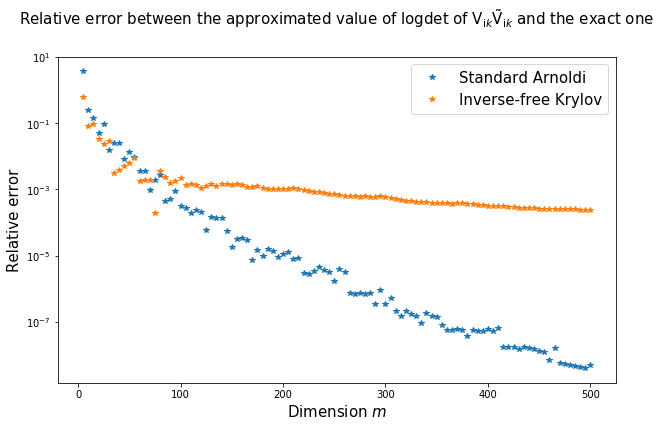

In [197]:
plt.figure(figsize = [10,6])
plt.semilogy(np.arange(5, 500+5, 5), err_arno, '*')
plt.semilogy(np.arange(5, 500+5, 5), err_kry, '*')
plt.xlabel('Dimension $m$', fontsize = 15)
plt.ylabel('Relative error', fontsize = 15)
plt.legend(['Standard Arnoldi', 'Inverse-free Krylov'], fontsize = 15)
plt.title('Relative error between the approximated value of logdet of $\mathsf{V}_{\mathrm{i}k}\~{\mathsf{V}}_{\mathrm{i}k}$ and the exact one', fontsize = 15, y = 1.08)
plt.savefig('two_methods_logdet_err.pdf')

# Inverse-free Krylov subspace method

In [169]:
x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
rho_ = 1

In [170]:
err_kry = []
for dim in np.arange(5, 500 + 5, 5):
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = dim, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    evals_kry = evalue + rho_
    
    logdet_ = 0 
    for i in range(len(evals_kry)):
        logdet_ += np.log(evals_kry[i])
    err_kry.append(abs(logdet - logdet_)/abs(logdet))

In [171]:
print(err_kry)

[0.6144766423887684, 0.08228721085074128, 0.0942035458970692, 0.03252681153141955, 0.02412157252140442, 0.029608803326728595, 0.003160761264560776, 0.0038448624731575827, 0.005110003863952236, 0.006320687564412544, 0.009077241158411168, 0.0017458202802637518, 0.0019052874294366979, 0.0019157792854761517, 0.0001939583961276505, 0.0036793844725981385, 0.0024649980088236613, 0.0016151268324192537, 0.0018283409028057667, 0.0022353677275055105, 0.0013642657591779815, 0.0014752385383978463, 0.0013851787998443476, 0.0011328859397210682, 0.001312276438949602, 0.001455888305997661, 0.0013152377311034793, 0.0014811138159062894, 0.001415535076384159, 0.001373388548300702, 0.0014330172298982478, 0.0013613617555451219, 0.0012287607745217703, 0.0011882431769745165, 0.0012457370262436963, 0.0010790000943933279, 0.0010581231760461273, 0.0010288108670415386, 0.001018703038319338, 0.0010442281817181689, 0.0010536988691827746, 0.001072542605556021, 0.0010201269813325162, 0.0009371544444302495, 0.00088906

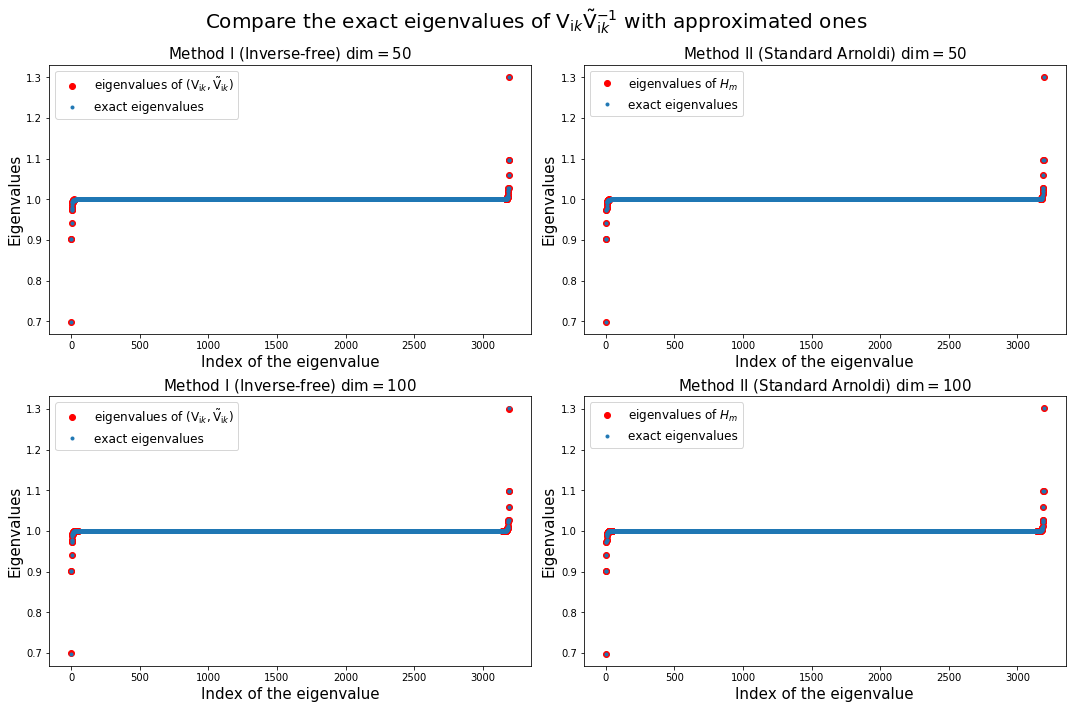

In [194]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.plot(range(25), evals_kry_50_s , 'ro', label = 'eigenvalues of $(\mathsf{V}_{\mathrm{i}k}, \~{\mathsf{V}}_{\mathrm{i}k})$')
ax1.plot(range(n - 25, n), evals_kry_50_l,  'ro')
ax1.plot(range(len(evals)), sorted(evals), '.', label = 'exact eigenvalues')
ax1.legend(fontsize = 12)
ax1.set_xlabel('Index of the eigenvalue', fontsize = 15)
ax1.set_ylabel('Eigenvalues', fontsize = 15)
ax1.set_title('Method I (Inverse-free) dim$= 50$', fontsize = 15)


ax2.plot(range(25), evals_H_50_s,  'ro', label = 'eigenvalues of $H_{m}$')
ax2.plot(range(n - 25, n), evals_H_50_l, 'ro')
ax2.plot(range(len(evals)), sorted(evals), '.', label = 'exact eigenvalues')
ax2.set_xlabel('Index of the eigenvalue', fontsize = 15)
ax2.set_ylabel('Eigenvalues', fontsize = 15)
ax2.set_title('Method II (Standard Arnoldi) dim$= 50$', fontsize = 15)
ax2.legend(fontsize = 12)

ax3.plot(range(50), evals_kry_100_s , 'ro', label = 'eigenvalues of $(\mathsf{V}_{\mathrm{i}k}, \~{\mathsf{V}}_{\mathrm{i}k})$')
ax3.plot(range(n - 50, n), evals_kry_100_l,  'ro')
ax3.plot(range(len(evals)), sorted(evals), '.', label = 'exact eigenvalues')
ax3.legend(fontsize = 12)
ax3.set_xlabel('Index of the eigenvalue', fontsize = 15)
ax3.set_ylabel('Eigenvalues', fontsize = 15)
ax3.set_title('Method I (Inverse-free) dim$= 100$', fontsize = 15)

ax4.plot(range(50), evals_H_100_s, 'ro' , label = 'eigenvalues of $H_{m}$')
ax4.plot(range(n - 50, n), evals_H_100_l, 'ro')
ax4.plot(range(len(evals)), sorted(evals), '.', label = 'exact eigenvalues')
ax4.set_xlabel('Index of the eigenvalue', fontsize = 15)
ax4.set_ylabel('Eigenvalues', fontsize = 15)
ax4.legend(fontsize = 12)
ax4.set_title('Method II (Standard Arnoldi) dim$= 100$', fontsize = 15)

fig.tight_layout()
fig.suptitle('Compare the exact eigenvalues of $\mathsf{V}_{\mathrm{i}k}\~{\mathsf{V}}_{\mathrm{i}k}^{-1}$ with approximated ones', fontsize = 20)
fig.subplots_adjust(top=0.9)
fig.savefig('Method_GEP_Hess_m.pdf')

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


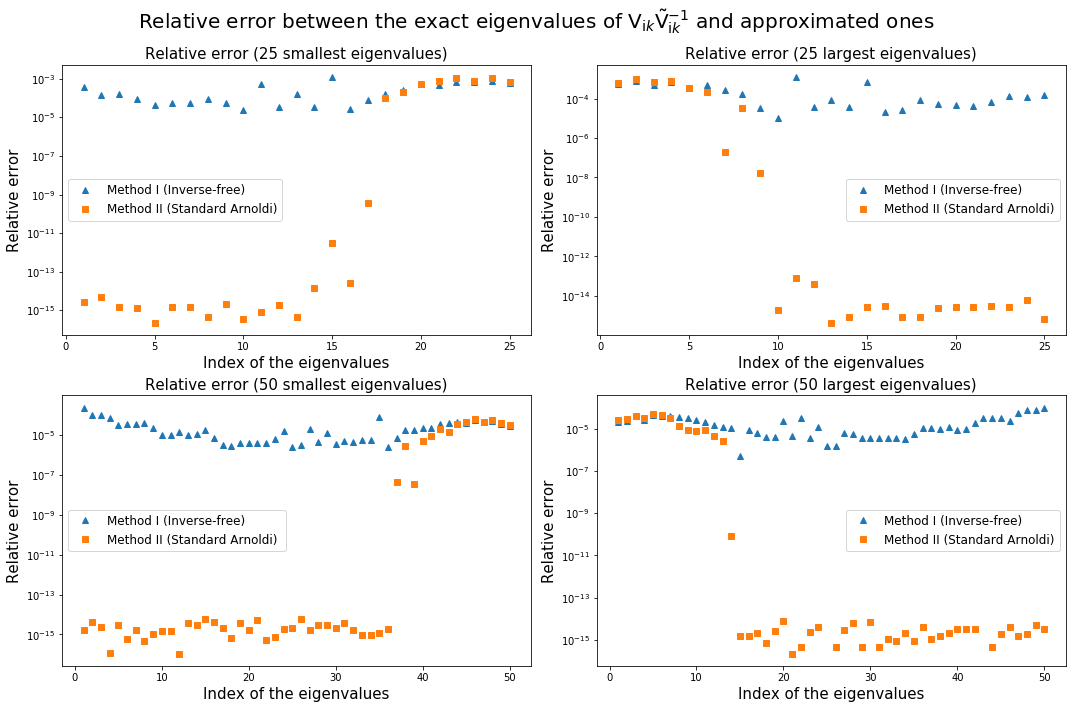

In [196]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.semilogy(range(1, 25+1), err_kry_50_s ,'^')
ax1.semilogy(range(1, 25+1), err_H_50_s ,'s' )
ax1.legend(['Method I (Inverse-free)', 'Method II (Standard Arnoldi)'], fontsize = 12)
ax1.set_xlabel('Index of the eigenvalues', fontsize = 15)
ax1.set_ylabel('Relative error', fontsize = 15)
ax1.set_title('Relative error (25 smallest eigenvalues)', fontsize = 15)

ax2.semilogy(range(1, 25+1), err_kry_50_l ,'^')
ax2.semilogy(range(1, 25+1), err_H_50_l ,'s')
ax2.legend(['Method I (Inverse-free)', 'Method II (Standard Arnoldi)'], fontsize = 12)
ax2.set_xlabel('Index of the eigenvalues', fontsize = 15)
ax2.set_ylabel('Relative error', fontsize = 15)
ax2.set_title('Relative error (25 largest eigenvalues)', fontsize = 15)

ax3.semilogy(range(1, 50+1), err_kry_100_s ,'^')
ax3.semilogy(range(1, 50+1), err_H_100_s ,'s')
ax3.legend(['Method I (Inverse-free) ', 'Method II (Standard Arnoldi) '], fontsize = 12)
ax3.set_xlabel('Index of the eigenvalues', fontsize = 15)
ax3.set_ylabel('Relative error', fontsize = 15)
ax3.set_title('Relative error (50 smallest eigenvalues)', fontsize = 15)

ax4.semilogy(range(1, 50+1), err_kry_100_l ,'^')
ax4.semilogy(range(1, 50+1), err_H_100_l ,'s')
ax4.legend(['Method I (Inverse-free)', 'Method II (Standard Arnoldi)'], fontsize = 12)
ax4.set_xlabel('Index of the eigenvalues', fontsize = 15)
ax4.set_ylabel('Relative error', fontsize = 15)
ax4.set_title('Relative error (50 largest eigenvalues)', fontsize = 15)
fig.tight_layout()
fig.suptitle('Relative error between the exact eigenvalues of $\mathsf{V}_{\mathrm{i}k}\~{\mathsf{V}}_{\mathrm{i}k}^{-1}$ and approximated ones', fontsize = 20)
fig.subplots_adjust(top=0.9)
fig.savefig('compare_two_methods_eig.pdf')

In [103]:
h = 0.1

r1 = 1
r2 = 1

dist = 3.0

sphere1 = bempp.api.shapes.sphere(r = r1, h=h, origin=((dist/2) + r1, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = r2, h=h, origin=(-((dist/2) + r2), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

N_wn = 20
ubound_wn = 4
lbound_wn = 0
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

results = []
for index2, point2 in enumerate(quad_points):

    wavenumber = -1j * np.log(point2)


    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    n = mat.shape[0]
    Id = np.eye(n)
    inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)  # inversion of the matrix M_{\infty} computed through the LU decomposition

    combined = inv_mat2.dot(mat)
    sign, logdet = slogdet(combined)

    results.append(logdet)
print(np.trapz(-np.array(results)/quad_points, quad_points)/(2*np.pi))

0.0010262850146008139


In [104]:
CasE_kry = []
CasE_arno = []
Err_kry = []
Err_arno = []
for dim in np.arange(5, 100+5, 5):

    results_kry = []
    results_arno = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)


        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

        n = mat.shape[0]
        
        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                                  [mat21_zero, mat22_inv]])  

        combined_inverse_free = inv_free_mat2.dot(mat)

        X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = dim,  ortho='dmgs')
        evals_H, evect_H = np.linalg.eig(H_combined[0:dim, :]) 

        x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
        rho_ = 1.0
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = dim, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        evalue_ = evalue + rho_

        logdet_kry = 0 
        for i in range(len(evalue_)):
            logdet_kry += np.log(evalue_[i])

        logdet_arno = 0 
        for i in range(len(evals_H)):
            logdet_arno += np.log(evals_H[i])

        results_kry.append(logdet_kry)
        results_arno.append(logdet_arno)
        
    cas_kry = np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi)
    cas_arno = np.trapz(-np.array(results_arno)/quad_points, quad_points)/(2*np.pi)
    print(cas_kry, cas_arno, 0.0010262850146008139)
    CasE_kry.append(cas_kry)
    CasE_arno.append(cas_arno)
    Err_kry.append(abs(cas_kry - 0.0010262850146008139)/0.0010262850146008139)
    Err_arno.append(abs(cas_arno - 0.0010262850146008139)/0.0010262850146008139)

0.0002182322453205587 0.0006527398483035607 0.0010262850146008139
0.0009962958511271032 0.0009693716088843173 0.0010262850146008139
0.001014170081866412 0.0010135310259149282 0.0010262850146008139
0.0010181966245469162 0.001011055188257731 0.0010262850146008139
0.0010222290074412494 0.0010246305688881212 0.0010262850146008139
0.0010229152591706282 0.0010256554561868469 0.0010262850146008139
0.0010233075443814227 (0.0010260982617729421+0j) 0.0010262850146008139
0.0010235163742322645 0.001026255414812836 0.0010262850146008139
0.0010235538094678464 (0.0010262807385704737+0j) 0.0010262850146008139
0.0010235790027556231 (0.00102627246769588+0j) 0.0010262850146008139
0.0010234700305673111 (0.0010262761674847175+0j) 0.0010262850146008139
0.0010234186355551353 (0.0010262828817661713+0j) 0.0010262850146008139
0.0010234489494891363 (0.0010262849818825658+0j) 0.0010262850146008139
0.0010234935132698367 (0.0010262851599640715+0j) 0.0010262850146008139
0.0010235146056899928 0.0010262851850899328 0.

In [95]:
len(err_arno)

100

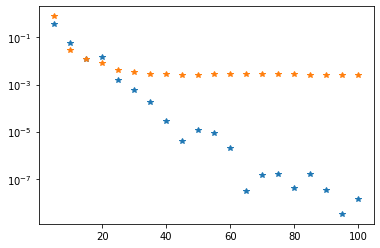

In [105]:
plt.semilogy(np.arange(5, 100+5, 5), Err_arno, '*')
plt.semilogy(np.arange(5, 100+5, 5), Err_kry, '*')

In [91]:
dim = 100
results_kry = []
results_arno = []
for index2, point2 in enumerate(quad_points):

    wavenumber = -1j * np.log(point2)


    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    n = mat.shape[0]
    
    mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
    mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

    inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                              [mat21_zero, mat22_inv]])  

    combined_inverse_free = inv_free_mat2.dot(mat)

    X_combined, H_combined = krypy.utils.arnoldi(combined_inverse_free, (np.ones(n)/np.linalg.norm(np.ones(n))).reshape((n,1)), maxiter = dim,  ortho='dmgs')
    evals_H, evect_H = np.linalg.eig(H_combined[0:dim, :]) 

    x = np.ones(mat.shape[0]) / np.linalg.norm(np.ones(mat.shape[0]))
    rho_ = 1.0
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(mat.shape[0],1), maxiter = dim, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    evalue_ = evalue + rho_

    logdet_kry = 0 
    for i in range(len(evalue_)):
        logdet_kry += np.log(evalue_[i])

    logdet_arno = 0 
    for i in range(len(evals_H)):
        logdet_arno += np.log(evals_H[i])

    results_kry.append(logdet_kry)
    results_arno.append(logdet_arno)

cas_kry = np.trapz(-np.array(results_kry)/quad_points, quad_points)/(2*np.pi)
cas_arno = np.trapz(-np.array(results_arno)/quad_points, quad_points)/(2*np.pi)

In [92]:
print(cas_kry, cas_arno)

0.043530368033945444 (0.043704022590485836+0j)
